<h1>Example: Gibbs Sampling</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
### General Imports ###
import numpy             as np
import numpy.linalg      as la
import scipy.linalg      as sla
import scipy.integrate    as spi
import pyLIQTR.sim_methods.quantum_ops  as  qops  
import matplotlib.pyplot  as plt
from itertools import combinations
import shadows as sh

<hr>
<h2><u> Quantum Gibbs States </u></h2>
<h3>Background</h3>
This notebook describes how pyLIQTR can be used to sample from Gibbs states. Gibbs states are mixed quantum states which describe systems in thermodynamic equilibrium with their environment at finite temperatures. Gibbs states are important towards quantum statistical mechanics and their properties have far-reaching applications from materials design to optimization and machine learning. We can define a Gibbs state for a given system using a density matrix of the form:

\begin{equation}
\rho_\beta = e^{-\beta H}/Z
\end{equation}

where $ Z = \text{Tr}e^{-\beta H}$ is the partition function, $\beta$ is inverse temperature, and $H$ is the system Hamiltonian. 

Let us begin by considering an example of a 3-qubit system subject to an XXZ-Heisenberg Hamiltonian. The details behind implementing such a Hamiltonian with `pyLIQTR` can be found in the 'Heisenberg' tutorial. Here, we calculate the Gibbs state for this example.

In [2]:
# Define Hamiltonian as in Heisenberg tutorials, using the XXZ model

# Hamiltonian parameters

N    =    3;       

J_z  =    1.0;

J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

In [3]:
# Generate input parameter sets
tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)

# Generate Hamiltonian array
H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)

With the Hamiltonian defined above, we need only specify an inverse temperature, and then we can calculate our Gibbs State.

In [4]:
# Let us define our inverse temperature as beta = 0.5
beta = 1.5

# Calculate Gibbs State
rho_beta = sla.expm(-beta*H)
Z = np.trace(rho_beta)
rho_beta = rho_beta/Z

<h3>Gibbs State Sampling</h3>

In these tutorials, we implement an algorithm described in Coopmans et al which rather than explicitly preparing Gibbs states, seeks to sample them by estimating their expectation values for some sets of operators. For this example, our operator set will consist of all one and two qubit Pauli operators, but in principle any set of Hermitian operators will do.

The following generates this operator set $O$, and calculates the 'true' expectation values of each operator for the Gibbs state calculated above.

In [5]:
# Define our set of operators as all one and two qubit Pauli operators (they need only be Hermitian)
op_tuples = list(combinations(range(N), 2))

paulis = [qops.px,qops.py,qops.pz]
O_list = []
O = []

# One qubit pauli operators over N qubits
for i in range(N):
    ops = [qops.id]*N

    op_ids = [3]*N

    for j in range(3):
        ops[i] = paulis[j]
        O.append(qops.multikron(ops))

        op_ids[i] = j
        O_list.append(op_ids.copy())

# Two qubit pauli operators over N qubits
for tuple in op_tuples:
    ops = [qops.id]*N
    op_ids = [3]*N
    for i in range(3):
        for j in range(3):
            ops[tuple[0]] = paulis[i]
            ops[tuple[1]] = paulis[j]
            O.append(qops.multikron(ops))

            op_ids[tuple[0]] = i
            op_ids[tuple[1]] = j
            O_list.append(op_ids.copy())

In [14]:
# Expectation values of operators for Gibbs State
Gbs_expct = sh.expect_set(O, rho_beta)

print('TRUE EXPECTATION VALUES:')
for expct in Gbs_expct:
    print(expct)

TRUE EXPECTATION VALUES:
(0.6088924978618702+0j)
-3.3285006695304986e-16j
(2.220446049250313e-16+0j)
(-0.3104951051177654+0j)
5.551115123125783e-17j
0j
(0.60889249786187+0j)
-2.220446049250313e-16j
(3.885780586188048e-16+0j)
(-0.6702405807740384+0j)
-1.6653345369377348e-16j
(5.551115123125783e-17+0j)
1.1102230246251565e-16j
(-0.6683111592086682+0j)
7.654467337747661e-17j
0j
2.7755575615628914e-17j
(-0.6539321506861399+0j)
(0.3455771516806042+0j)
1.3877787807814457e-16j
(-5.551115123125783e-17+0j)
-2.7755575615628914e-17j
(0.3383756497672158+0j)
-8.998878031629687e-17j
(-1.1102230246251565e-16+0j)
-5.551115123125783e-17j
(0.3094308613665861+0j)
(-0.6702405807740386+0j)
-5.551115123125783e-17j
(-1.1102230246251565e-16+0j)
5.551115123125783e-17j
(-0.6683111592086683+0j)
2.7755575615628914e-17j
(1.1102230246251565e-16+0j)
5.551115123125783e-17j
(-0.65393215068614+0j)


<h3>Classical Shadows</h3>

Specifically, this algorithm estimates the expectation values using the Classical Shadows. Classical shadow tomography is used to efficiently predict properties of a quantum state through classical representations constructed from randomized measurements. Consider an $n$-qubit state $\rho$, prepared by some circuit (in this case our Gibbs state). The procedure works by applying some unitary transformation $V$, chosen randomly from some ensemble, to $\rho$ before measuring the resulting state ($V\rho V^{\dagger}$) in the computational basis for some outcome $\ket{b}$. 

From the measurement outcome $\ket{b}$, we store the 'reverse' operation of our random measurement in classical memory: $V^{\dagger} \ket{b}\bra{b} V$. We call this value a 'snapshot' of our state. The average of these snapshots defines a quantum measurement channel, $\mathcal{M}$. Thus, we can construct a Classical Shadow of $\rho$ with respect to $V$ and $\ket{b}$ like so:

\begin{equation}
\hat{\eta}_{V,b} = \mathcal{M}^{-1}(V^{\dagger}\ket{b}\bra{b} V)
\end{equation}

The inverse of $\mathcal{M}$ is a linear map, which depends on the ensemble from which $V$ is sampled. Note that this linear map is not CPTP, but since we only use it for classical post-processing, this does not pose a problem. Two common ensembles used for generating random unitaries are

1. Random Clifford measurements: $V \in Cl(2^n)$
2. Random Pauli measurements: $V = V_1 \otimes ... \otimes V_n \in Cl(2)^{\otimes n}$

The first is equivalent to generating a random clifford circuit (for which a polynomial time algorithm exists) while the second is equivalent to measuring each qubit in a randomly chosen pauli-X, Y, or Z basis. For Clifford measurements, $\hat{\eta}_{V,b} = (2^n + 1)V^{\dagger}\ket{b}\bra{b} V - I$ while for Pauli measurements $\hat{\eta}_{V,b} = \bigotimes^{n}_{j=1}(3 V^{\dagger}_j\ket{b_j}\bra{b_j} V_j - I) $.

Given that random clifford circuits include entangling gates, the second approach is considered more NISQ-friendly. More importantly for the purpose of our simulations, the second approach can be implemented in linear time, so we use it here for scalability (though `pyLIQTR` does support use of random clifford circuits in the `shadows` module).

The state $\rho$ can be clasically reconstructed as the expectation value of our shadows over random clifford unitaries: $\rho = \mathbb{E}_{V,b}[\hat{\eta}_{V,b}]$. Thus, for any of our operators $O_j \in O$ :

\begin{equation}
\braket{O_j}_{\rho} = \text{Tr}(\rho O_j) = \text{Tr}(\mathbb{E}[\hat{\eta}_{V,b}] O_j) = \mathbb{E}[\text{Tr}(\hat{\eta}_{V,b} O_j)] = \mathbb{E}_{V,b}[\braket{O_j}_{\hat{\eta}_{V,b}}]
\end{equation}

In other words, the expectation value of an operator for a given state can be estimated by an average of the expectation values for many classical shadows. 

<hr>

Now, we consider the question of <i>how many</i> classical shadows we should use for a given expectation value estimation, and <i>how</i> we should average them. The classical shadow protocol typically employs a median of means estimator, that is, a sample of $n_s$ shadows is broken into $K$ equally sized sets of size $S$ and we take the median of the $K$ set means (each calculated from $S$ shadows). The values of $S$ and $K$ are directly related to the performance of our estimation and our observables. Specifically:

\begin{equation}
S > \frac{2\sigma^2}{\epsilon^2}
\end{equation}

where $\epsilon$ is our desired error bound. Also note that for random pauli measurements $\sigma^2 \approx 3^{\text{locality}(O)} - (\text{Tr}\rho_\beta O)^2$.

\begin{equation}
K = (9/2)\log(M/\delta) 
\end{equation}

where  $M$ is the number of observables whose expectation values we are estimating, and the probability that a given estimation falls within our error bound is $1-\delta$.

Thus, we can conclude that for a given $\epsilon, \delta$ we need at least

\begin{equation}
n_s > SK = 9\frac{\sigma^2}{\epsilon^2}\log(M/\delta)
\end{equation}

shadows. Crucially, this suggests that we can estimate $M$ expectation values with $O(\log M)$ measurements!

In [15]:
delta = 0.01
epsilon = np.array([1 - 0.1*x for x in range(9)])


vars = []
for o_j in O:
    vars.append(3**2 - abs(np.trace(rho_beta@o_j)**2))

K = int(np.rint((9/2)*np.log(len(O)/delta)))
S = np.rint((2/(epsilon**2))*max(vars)).astype(int) + np.array([1]*len(epsilon)) # Fulfill strictly greater than requirement

sizes = list(K*S)
print('number of shadows required for each error tolerance, epsilon:')
print(sizes)


number of shadows required for each error tolerance, epsilon:
[703, 851, 1073, 1406, 1887, 2701, 4218, 7437, 16687]


The following calculates such estimates for various-sized sets of classical shadows of $\rho_\beta$. The equations described above for calculating classical shadows are implemented in the `shadows` module and called here. As the results show, the more shadows we use the better the estimate, and errors can get very small, suggesting that classical shadows are indeed useful estimation tools in this case.

703
851
1073
1406
1887
2701
4218
7437
16687


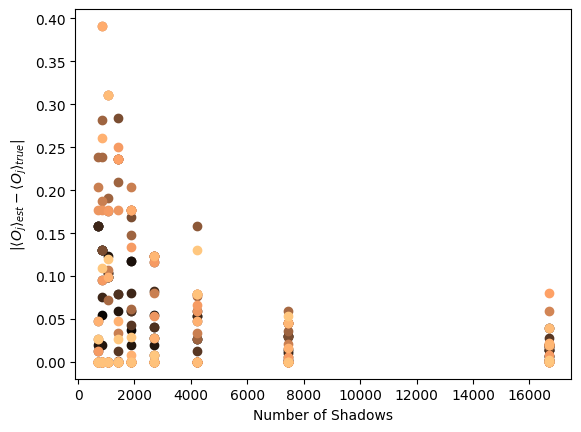

In [20]:
# Classical Shadows for exact  state
gibshadow_errors = []

# Calculate n_s-sized sets of shadows, their expectation values, and errors
for n_s in sizes:
    estimates = []

    print(n_s)
    for i in range(n_s):
        estimates.append(sh.shadow_estimation(rho_beta, N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)
    error = abs(np.subtract(Gbs_expct, shadow_expct))
    gibshadow_errors.append(error)


plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(gibshadow_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.show()

The above shows the error in expectation value between the classical shadow estimation and  our operators, for different numbers of shadows. We can compare this to the theoertical error bound based on our $\epsilon$ as calculated earlier:

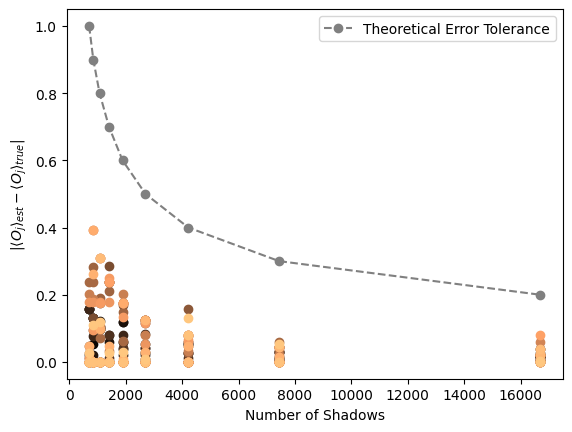

In [21]:
plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(gibshadow_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,abs(epsilon), '--o', color='grey', label='Theoretical Error Tolerance')
plt.legend()
plt.show()

<h3>Thermal Pure Quantum States </h3>

This algorithm estimates expectation values using the classical shadows specifically of Thermal Pure Quantum (TPQ) states. A TPQ state is a pure state which represents an equilibrium state; in other words, a TPQ state $\ket{\psi_\beta}$ can estimate expectation values for a thermal mixed state, like our Gibbs state. Thus, Coopmans et al argue that the classical shadows of the Gibbs state and the appropriately constructed TPQ states should be roughly the same, and we can estimate our expectation values with the latter. Moreover, they show that such TPQ states can be generated through imaginary time evolution like so:

\begin{equation}
\ket{\psi_\beta} = \frac{e^{-\beta H/2}U\ket{0}}{\sqrt{\braket{0|U^{\dagger}e^{-\beta H}U|0}}}
\end{equation}

Where $U$ is a random clifford unitary (generated in the `shadows` module using an algorithm described in Dankert et al), and the exponential represents the imaginary time evolution under our Hamiltonian. For now, let us verify that the shadows of this state when calculated exactly will predict expectation values about as well as the exact Gibbs state's shadows. In future tutorials, we will delve into how we can prepare TPQ states using a quantum circuit.

703
851
1073
1406
1887
2701
4218
7437
16687


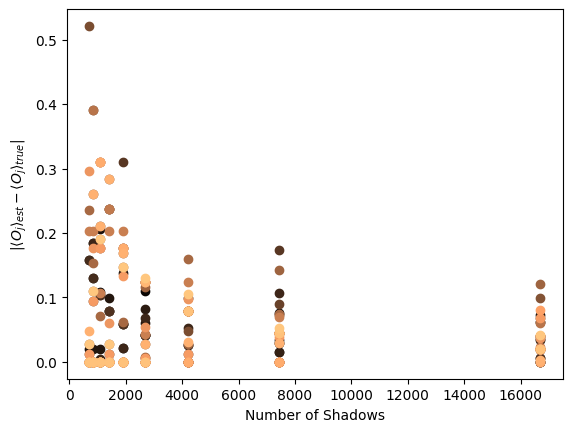

In [22]:
# Classical Shadows for Explicitly calculated TPQ states
tpq_errors = []

# Calculate n_s-sized sets of shadows, their expectation values, and errors
for n_s in sizes:
    estimates = []

    print(n_s)
    for i in range(n_s):
        # Calculate "exact" TPQ 
        U = sh.random_unitary(N, 0.1)
        psi0 = qops.multikron([qops.sz_u]*N)
        phi = np.matmul(U, psi0) 
        psiB = np.matmul(sla.expm(-beta*H/2), phi) # imaginary time evolution
        psiB = psiB/la.norm(psiB) # normalize

        estimates.append(sh.shadow_estimation(np.outer(psiB, psiB.conj()), N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)
    error = abs(np.subtract(Gbs_expct, shadow_expct))
    tpq_errors.append(error)

plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(tpq_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.show()

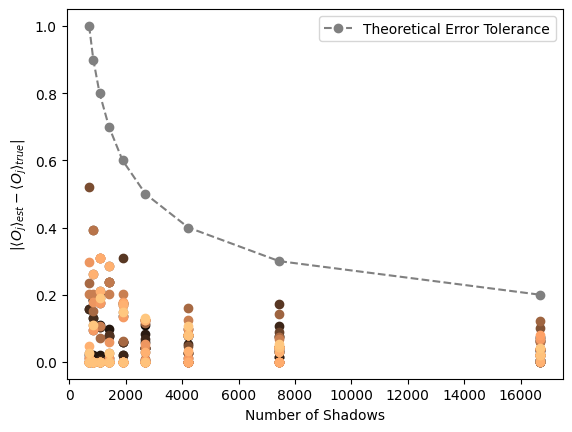

In [23]:
plt.xlabel('Number of Shadows')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
i = 0
for errors in np.array(tpq_errors).T:
    i += 1
    plt.scatter(sizes, errors, color=plt.cm.copper(i/len(O)))
plt.plot(sizes,epsilon, '--o', color='grey', label='Theoretical Error Tolerance')
plt.legend()
plt.show()

As the results show, the Pure Thermal Shadows estimate the operators' expectation values within our theoretical error threshold. Comparing the average error for expectation values calculated using the TPQ with those using the Gibbs state, we see that TPQ states perform nearly as well as the Gibbs state shadows:

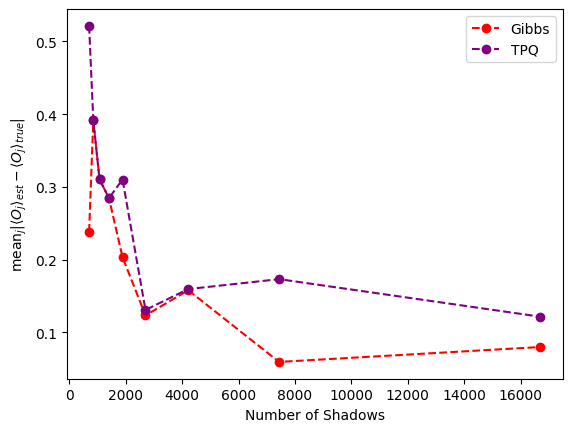

In [24]:
plt.xlabel('Number of Shadows')
plt.ylabel(r'mean$_j | \langle O_j \rangle _{est} - \langle O_j \rangle _{true}$|')
plt.plot(sizes, np.max(gibshadow_errors, axis=1), '--o', color='red', label = 'Gibbs')
plt.plot(sizes,np.max(tpq_errors, axis=1), '--o', color='purple', label = 'TPQ')
plt.legend()
plt.show()

[1] L. Coopmans, Y. Kikuchi, and M. Benedetti, “Predicting Gibbs-State Expectation Values with Pure Thermal Shadows,” PRX Quantum, vol. 4, no. 1, Jan. 2023, doi: 10.1103/prxquantum.4.010305. 

[2] H.-Y. Huang, R. Kueng, and J. Preskill, “Predicting many properties of a quantum system from very few measurements,” Nature Physics, vol. 16, no. 10, pp. 1050–1057, Jun. 2020, doi: 10.1038/s41567-020-0932-7.

[3] C. Dankert, R. Cleve, J. Emerson, and E. Livine, “Exact and approximate unitary 2-designs and their application to fidelity estimation,” Physical Review A, vol. 80, no. 1, Jul. 2009, doi: 10.1103/physreva.80.012304. 

[4] B. Doolittle and R. Wiersema, Classical shadows — pennylane.ai. https://pennylane.ai/qml/demos/tutorial_classical_shadows, 2021. [Online]. Available: https://pennylane.ai/qml/demos/tutorial_classical_shadows